In [50]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [99]:
df = pd.concat(pd.read_pickle(p) for p in list(Path(
    '/share/compling/data/sanpi/2_hit_tables/advadj').glob('bigram-*hits.pkl.gz'))[:10])

bigrams = df.loc[~df.duplicated(['token_str', 'hit_text']), [
    'adv_lemma', 'adj_lemma', 'hit_text']]


In [101]:
scale_dict = {
    'NON_G': ('dead', 'alive', 'existing', 'extinct', 'pregnant'),
    'OPEN': ('big', 'large', 'small', 'cheap', 'expensive', 'deep', 'shallow',
             'fat', 'thin', 'short', 'tall', 'long', 'wealthy', 'rich', 'poor', 'strong', 'weak',
            #  'wide', 'narrow', 'loud', 'quiet', 'soft', 'hard', 'high', 'low'
             ),
    'LOW_CLOSE': ('bent', 'bumpy', 'crooked', 'dangerous', 'dirty', 'impure', 'incomplete', 'wet'),
    'UP_CLOSE': ('straight', 'smooth', 'safe', 'clean', 'pure', 'complete', 'dry'),
    'TOT_CLOSE': ('open', 'closed', 'full', 'empty', 'opaque', 'transparent')
}
scale_df = pd.Series(scale_dict).to_frame().reset_index().rename(
    columns={0: 'adj', 'index': 'scale_type'})
scale_defs = scale_df.explode('adj').set_index('adj').to_dict()['scale_type']

adv_counts = bigrams.adv_lemma.value_counts()
adverbs = adv_counts.loc[adv_counts > 5000].index.to_list()
B = bigrams.loc[bigrams.adv_lemma.isin(adverbs) 
                & bigrams.adj_lemma.isin(scale_defs.keys()), :]
B.describe()


,adv_lemma,adj_lemma,hit_text
count,456108,456108,456108
unique,119,42,6979
top,very,big,more expensive
freq,81342,45133,11817


In [102]:
B = B.assign(adv_lemma=B.adv_lemma.str.lower().astype('category'),
             adj_lemma=B.adj_lemma.str.lower().astype('category'),
             scale_type=B.adj_lemma.apply(lambda a: scale_defs[a]))
total = len(B)
scale_percents = B.value_counts('scale_type', normalize=True) * 100
scale_percents.round(1)

scale_type
OPEN         69.928394
UP_CLOSE     11.080051
TOT_CLOSE     8.239277
LOW_CLOSE     6.979049
NON_G         3.773229
dtype: float64

In [103]:
adv_totals = B.value_counts('adv_lemma')
adv_counts = adv_totals.to_frame().rename(columns={0:'total'})
for st, aa in B.groupby('scale_type'): 
    # print(aa.value_counts(['scale_type','adv_lemma']))
    adv_counts.loc[:, st] = aa.value_counts('adv_lemma') 
    # print('---------------------------')
# adv_counts.describe().round(1)

,total,LOW_CLOSE,NON_G,OPEN,TOT_CLOSE,UP_CLOSE
count,119.0,119.0,119.0,119.0,119.0,119.0
mean,3832.8,267.5,144.6,2680.2,315.8,424.7
std,9792.6,821.3,561.6,7952.5,794.1,911.6
min,5.0,0.0,0.0,1.0,0.0,0.0
25%,278.5,10.0,4.0,93.5,16.0,35.0
50%,853.0,29.0,13.0,373.0,55.0,110.0
75%,2411.0,123.5,75.0,1281.0,209.5,356.0
max,81342.0,5563.0,5411.0,68240.0,6819.0,6091.0


In [104]:
comparison_index = pd.DataFrame(index=adv_counts.index, columns=scale_dict.keys())
for st in scale_dict.keys(): 
    adv_counts.loc[:, f'adv{st}_percent'] = adv_counts[st] / adv_counts.total * 100
    comparison_index.loc[:, st] = adv_counts[f'adv{st}_percent'] / scale_percents[st]
comparison_index.loc[:, 'total_ratio'] = B.adv_lemma.value_counts(normalize=True)
# adv_counts

,total,LOW_CLOSE,NON_G,OPEN,TOT_CLOSE,UP_CLOSE,advNON_G_percent,advOPEN_percent,advLOW_CLOSE_percent,advUP_CLOSE_percent,advTOT_CLOSE_percent
adv_lemma,,,,,,,,,,,
very,81342,4319,310,68240,2382,6091,0.381107,83.892700,5.309680,7.488137,2.928376
too,39023,1818,32,35291,737,1145,0.082003,90.436409,4.658791,2.934167,1.888630
more,31433,4859,801,15414,6819,3540,2.548277,49.037636,15.458276,11.262049,21.693761
much,29754,101,853,26450,349,2001,2.866841,88.895611,0.339450,6.725146,1.172952
as,25977,1348,299,19040,1222,4068,1.151018,73.295608,5.189206,15.660007,4.704161
...,...,...,...,...,...,...,...,...,...,...,...
socially,37,11,2,15,1,8,5.405405,40.540541,29.729730,21.621622,2.702703
purely,19,1,0,7,3,8,0.000000,36.842105,5.263158,42.105263,15.789474
directly,14,2,0,4,5,3,0.000000,28.571429,14.285714,21.428571,35.714286


In [105]:
# comparison_index.round(3)

,NON_G,OPEN,LOW_CLOSE,UP_CLOSE,TOT_CLOSE,total_ratio
adv_lemma,,,,,,
very,0.101,1.200,0.761,0.676,0.355,0.178
too,0.022,1.293,0.668,0.265,0.229,0.086
more,0.675,0.701,2.215,1.016,2.633,0.069
much,0.760,1.271,0.049,0.607,0.142,0.065
as,0.305,1.048,0.744,1.413,0.571,0.057
...,...,...,...,...,...,...
socially,1.433,0.580,4.260,1.951,0.328,0.000
purely,0.000,0.527,0.754,3.800,1.916,0.000
directly,0.000,0.409,2.047,1.934,4.335,0.000


In [106]:
examples = [] 
n = 3
for st in scale_dict.keys(): 
    examples += comparison_index[st].nlargest(n).index.to_list()
    examples += comparison_index[st].nsmallest(n).index.to_list()
examples = list(set(examples))

In [107]:
def heatmap(df):
    # Displaying dataframe as an heatmap
    # with diverging colourmap as RdYlBu
    plt.imshow(df, cmap ="viridis")
    plt.autoscale(enable=True, axis='both')
    # Displaying a color bar to understand
    # which color represents which range of data
    plt.colorbar()
    
    # Assigning labels of x-axis 
    # according to dataframe
    plt.xticks(range(len(df.columns)), df.columns)
    
    # Assigning labels of y-axis 
    # according to dataframe
    plt.yticks(range(len(df.index)), df.index)
    
    # Displaying the figure
    plt.show()

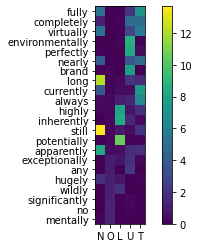

In [108]:
heatmap(comparison_index.loc[examples, scale_dict.keys()].sort_values('OPEN').rename(
    columns={'NON_G':'N',
             'OPEN': 'O',
             'LOW_CLOSE': 'L', 
             'UP_CLOSE': 'U', 
             'TOT_CLOSE': 'T'}))

In [109]:
# for scale in scale_type_dict.keys():
#     is_scale = scale_hits.adj_lemma.isin(scale_type_dict[scale])
#     scale_df = defined_hits.loc[is_scale, :].assign(scale_type=scale)
#     scale_count = len(scale_hits)
#     scale_percent = scale_count/total
#     adv_scale_df = pd.crosstabulate(scale_count, index=B.adv_lemma, columns=B.adj_lemma)
